In [7]:
#data ML

NOW THE REGRESSION THAT INCORPORATES BOTH PATTERNS DATA AND SURVEY DATA:




    ||  ||  ||  ||  ||  ||  ||  ||  
    ||  ||  ||  ||  ||  ||  ||  ||  
    \/  \/  \/  \/  \/  \/  \/  \/  

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import pandas as pd
import numpy as np
import ipynb
import os
import seaborn as sns
from ipynb.fs.full.SurveyUpload import uploadSurvey
#from ipynb.fs.full.DataUpload import getPatterns
#from ipynb.fs.full.DataUpload import getUserDay
import json
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
from sklearn.impute import SimpleImputer
from itertools import product
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV




In [3]:
def getUserDay(df, user, day):
    """
    user [str] - in the form of the user's anonymized name (i.e. "Monkey"). Make sure to use caps if necessary
    date [str] - in the form YEAR-MONTH-DAY (i.e. "2023-03-30")
    """
    user_day = df[(df.source_file == (user + "-patternsExport.json")) & (df.date == day)]

    #this fills in an endtime for the last app used that day - right now it assumes 1 minute of usage, but you could also just cut the last app from the df
    if not user_day.empty:
        user_day.iloc[-1, user_day.columns.get_loc('end_time')] = user_day.iloc[-1, user_day.columns.get_loc('datetime')] + pd.Timedelta(minutes=1)
        return user_day
    else:
        print(f"No data found for user '{user}' on day '{day}'")
    return None


ML model that tries to predict:
1. Task Completion (Yes or No)
2. Productivity score (1-10)

Using the following data:
1. User survey data from the morning
2. User survy data from the morning and noon
3. User survy data from the morning and noon and # of people talked to / # meetings

And using these models:
1. Basic multiple linear regression
2. Logistic regression
3. SVM
4. More?

In [4]:
df = uploadSurvey()
df['date'] = df['time'].dt.date
morning = df[df['TOD'] == 0]
noon = df[df['TOD'] == 1]
evening = df[df['TOD'] == 2]
df.head()


,time,name,description,sad_happy,stressed_relaxed,unmotivated_motivated,distracted_focused,unaccomplished_accomplished,bored_interested,angry_calm,...,productivity,TOD,when_focus,when_distracted,total_interactions,total_tasks,total_breaks,mind_focus,meaningful,date
0,2023-04-17 09:02:42.287,Lion,Eagerness to go about my To Do's,4,3,3,3,4,4,4,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
1,2023-04-17 09:04:59.898,Rabbit,"monday morning mood, however, motivated to sta...",3,2,4,2,3,4,3,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
2,2023-04-17 09:14:51.081,Snake,I am stressed and feel under pressure.,4,2,3,3,2,3,3,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
3,2023-04-17 09:20:42.626,Cat,"Stressed, anxious, trying to get into focus mo...",3,2,2,3,3,2,3,...,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
4,2023-04-17 09:35:00.882,Horse,"medium motivated, bit stressed, loads of meeti...",3,2,3,4,3,2,4,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17


In [ ]:
#patterns = getPatterns()
#patterns.head()

,createdAt,title,name,bundleIdentifier,url,source_file,date,time,datetime,end_time,delta,base_url,category,user
0,7.018782e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,2023-03-30,14:10:42.150009033,2023-03-30 14:10:42.150009033,2023-03-30 14:10:50.292375000,0 days 00:00:08.142365967,<NA>,[Shopping],Monkey
1,7.018783e+08,,Preview,com.apple.Preview,,Monkey-patternsExport.json,2023-03-30,14:10:50.292375,2023-03-30 14:10:50.292375000,2023-03-30 14:10:55.191275879,0 days 00:00:04.898900879,<NA>,[Entertainment],Monkey
2,7.018783e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,2023-03-30,14:10:55.191275879,2023-03-30 14:10:55.191275879,2023-03-30 14:11:12.651991943,0 days 00:00:17.460716064,<NA>,[Shopping],Monkey
3,7.018783e+08,,Notion,notion.id,,Monkey-patternsExport.json,2023-03-30,14:11:12.651991943,2023-03-30 14:11:12.651991943,2023-03-30 14:11:24.028187988,0 days 00:00:11.376196045,<NA>,[Professional Resources & Tools],Monkey
4,7.018783e+08,,Slack,com.tinyspeck.slackmacgap,,Monkey-patternsExport.json,2023-03-30,14:11:24.028187988,2023-03-30 14:11:24.028187988,2023-03-30 14:11:26.361884033,0 days 00:00:02.333696045,<NA>,"[Communication & Collaboration, Communication ...",Monkey


In [5]:
patterns = pd.read_csv('embedded_data')
patterns.head()

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_80224/1956938311.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  patterns = pd.read_csv('embedded_data')


,createdAt,title,name,bundleIdentifier,url,source_file,event,properties,date,time,datetime,end_time,delta,base_url,user,combined,ada_embedding
0,7.018799e+08,"usebeams.com - Calendar - Week of March 26, 2023",Google Chrome,com.google.Chrome,https://calendar.google.com/calendar/u/0/r/wee...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:38:38.991083984,2023-03-30 14:38:38.991083984,2023-03-30 14:43:19.208863037,0 days 00:04:40.217779053,https://calendar.google.com/,Monkey,https://calendar.google.com/calendar/u/0/r/wee...,"[-0.007639219518750906, -0.026348605751991272,..."
1,7.018802e+08,Re: Erik x beams - leona@usebeams.com - usebea...,Google Chrome,com.google.Chrome,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:43:37.038793945,2023-03-30 14:43:37.038793945,2023-03-30 14:43:43.726995117,0 days 00:00:06.688201172,https://mail.google.com/,Monkey,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,"[0.010895753279328346, -0.0047221616841852665,..."
2,7.018808e+08,NaN,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Kick-Off-Messag...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:52:52.228797852,2023-03-30 14:52:52.228797852,2023-03-30 14:52:56.907240967,0 days 00:00:04.678443115,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Kick-Off-Messag...,"[-0.004148750565946102, -0.011549131013453007,..."
3,7.018808e+08,(9+) Kick-Off Message,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Kick-Off-Messag...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:53:15.003209961,2023-03-30 14:53:15.003209961,2023-03-30 14:55:31.685331055,0 days 00:02:16.682121094,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Kick-Off-Messag...,"[-0.009607917629182339, -0.013429478742182255,..."
4,7.018809e+08,NaN,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Experiment-Desi...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:55:39.450079102,2023-03-30 14:55:39.450079102,2023-03-30 14:55:50.098559082,0 days 00:00:10.648479980,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Experiment-Desi...,"[-0.001701490138657391, -0.01200355589389801, ..."


In [11]:
type(patterns.iloc[0]['category'][0])

str

In [13]:
def readJSON(file_name):
    with open(file_name, 'r') as json_file:
        loaded_data = json.load(json_file)
        return loaded_data
    
def reverse_dict_handling_lists(original):
    reversed_dict = {}

    # Helper function to handle the value and its associated key
    def handle_value(value, key):
        if value in reversed_dict:
            # If you want to store multiple keys for a single value,
            # then you can change the following line to append to a list or another structure.
            # For now, the new key will overwrite the old one.
            reversed_dict[value] = key  
        else:
            reversed_dict[value] = key

    for key, value_list in original.items():
        if isinstance(value_list, list):  # Check if the main value is a list
            for value in value_list:
                if isinstance(value, list):  # Check if the value inside the list is another list (nested)
                    for nested_value in value:
                        handle_value(nested_value, key)
                else:
                    handle_value(value, key)
        else:  # If the main value is not a list
            handle_value(value_list, key)
                
    return reversed_dict



In [14]:
categories = readJSON('categoriesNew.json')
catlist = list(categories.keys())
reverse_categories = reverse_dict_handling_lists(categories)

In [15]:
patternsSummary = pd.DataFrame(columns=catlist)
patternsSummary['name'] = np.nan
patternsSummary['date'] = np.nan
patternsSummary.head()

,Professional Resources & Tools,Communication & Collaboration,Research & Information Gathering,News & Current Events,Social Media & Networking,Entertainment,Shopping,Financial & Administrative,Personal Interest,Education & Development,name,date


In [16]:
# Getting unique values from each column
unique_pairs = []
for name in patterns['user'].unique():
    name_df = patterns[patterns.user == name]
    for date in name_df['date'].unique():
        unique_pairs.append((name, date))



In [17]:
#calculating summary stats for each userday and putting them in patternsSummary
for name, date in unique_pairs:
    summary_stats = {key: None for key in categories.keys()}
    userday = getUserDay(patterns, name, date)
    if userday['delta'].dtype != 'timedelta64[ns]':
        userday['delta'] = pd.to_timedelta(userday['delta'])

    # Extract total seconds using .loc[]
    userday.loc[:, 'delta_seconds'] = userday['delta'].dt.total_seconds()

    # Your existing logic
    for category in summary_stats.keys():
        filtered_userday = userday[userday['category'].str[0] == category]
        summary_stats[category] = filtered_userday['delta_seconds'].sum()
    
    summary_stats['name'] = name
    summary_stats['date'] = date

    temp_df = pd.DataFrame([summary_stats])

    patternsSummary = pd.concat([patternsSummary, temp_df], ignore_index=True)

patternsSummary.head()
    

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_1339/675617661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userday['delta'] = pd.to_timedelta(userday['delta'])
/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_1339/675617661.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userday.loc[:, 'delta_seconds'] = userday['delta'].dt.total_seconds()
/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_1339/675617661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

,Professional Resources & Tools,Communication & Collaboration,Research & Information Gathering,News & Current Events,Social Media & Networking,Entertainment,Shopping,Financial & Administrative,Personal Interest,Education & Development,name,date
0,3748.990493,2468.724333,1.251960,0.000000,0.0,12.823915,133.160182,0.0,0.0,0.0,Monkey,2023-03-30
1,17957.207693,11952.519824,35.985327,0.000000,0.0,3.874271,62.724234,0.0,0.0,0.0,Monkey,2023-04-03
2,22423.126888,11625.067770,12.774175,0.000000,0.0,0.000000,38.961567,0.0,0.0,0.0,Monkey,2023-04-04
3,20218.444919,17673.395769,55.572109,0.000000,0.0,489.749694,216.116303,0.0,0.0,0.0,Monkey,2023-04-05
4,429926.204370,12236.173021,0.000000,188.088042,0.0,367.038057,118.361917,0.0,0.0,0.0,Monkey,2023-04-06


In [18]:
#Xcols = ['name', 'sad_happy', 'stressed_relaxed', 'unmotivated_motivated', 'distracted_focused', 'unaccomplished_accomplished', 'bored_interested', 'angry_calm', 'productivity']
ycols = ['productivity']

X = pd.DataFrame(columns=catlist)
y = pd.DataFrame(columns=ycols)

In [19]:
#First find which patterns datasets are related to the survey results

for index, row in patternsSummary.iterrows():
    date_value = str(row['date'])
    name_value = row['name']
    X_vals = patternsSummary.loc[index, catlist]

    evening_matching_rows = evening[(evening['date'].astype(str) == date_value) & (evening['name'] == name_value)]
    
    # If there's a match, grab the values and append to X and y
    if not evening_matching_rows.empty:
        y_vals = evening_matching_rows[ycols].iloc[0]
        X.loc[X.shape[0]] = X_vals.tolist()
        y.loc[y.shape[0]] = y_vals.tolist()


In [63]:
print(len(X))

90


In [20]:
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)
y_imputed = imputer.fit_transform(y)
y = pd.DataFrame(y_imputed, columns=y.columns)

In [21]:
reg = LinearRegression()

# Fit the model
reg.fit(X, y)

# Predictions
y_pred = reg.predict(X)

In [ ]:
#TRY OTHER MODEL!

othermodel = othermodel()

In [22]:
# Print coefficients and intercept
print("Intercept:", reg.intercept_)

for idx, coef in enumerate(reg.coef_[0]):
    print(catlist[idx], ": ", coef)

# Print R-squared and MSE
print("R-squared:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))

Intercept: [6.94169683]
Professional Resources & Tools :  6.733122887704222e-07
Communication & Collaboration :  -7.422604961309083e-05
Research & Information Gathering :  -2.0382493931797151e-07
News & Current Events :  9.671375422702664e-05
Social Media & Networking :  0.00031898234203704863
Entertainment :  0.00035702526731856303
Shopping :  2.2146495003726923e-06
Financial & Administrative :  0.000447717635155161
Personal Interest :  -5.708309188937001e-06
Education & Development :  0.00030345471304684264
R-squared: 0.2943495538052082
Mean Squared Error: 2.603066090407454


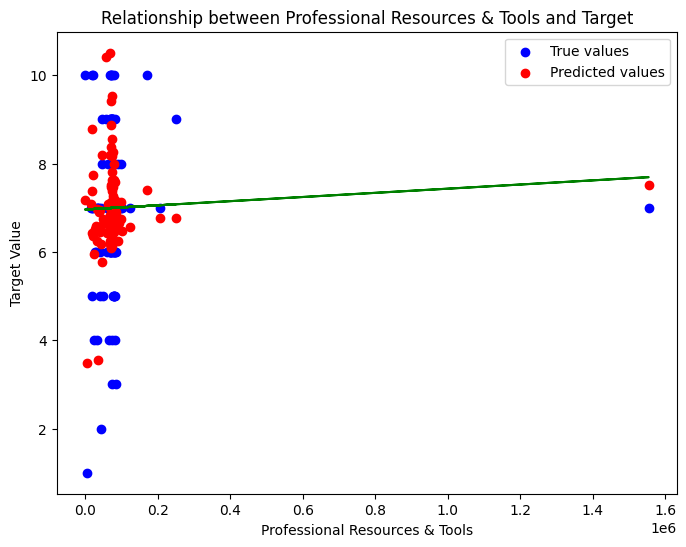

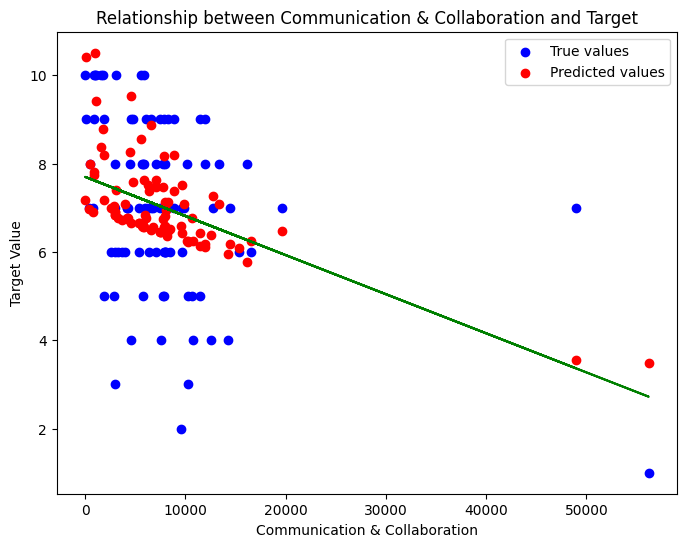

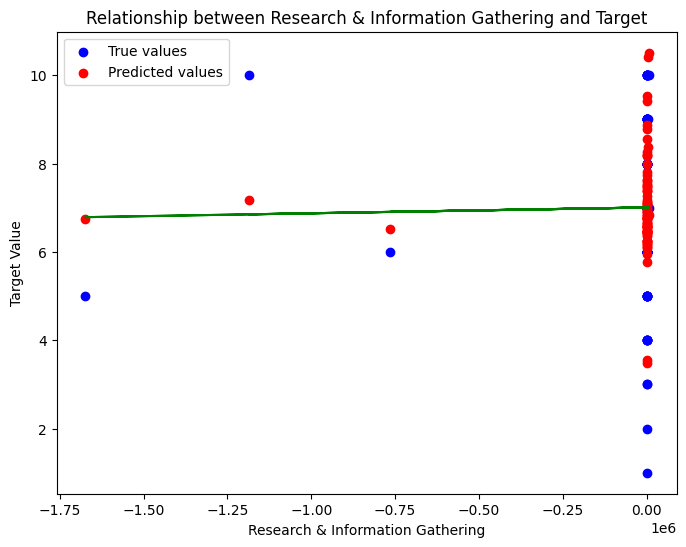

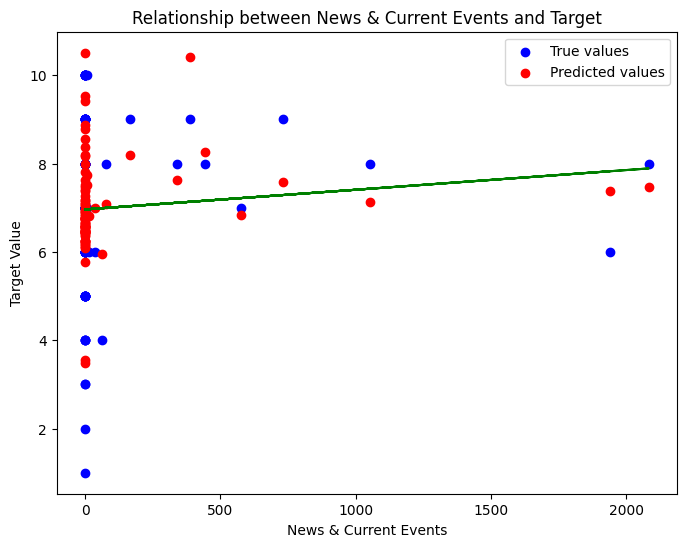

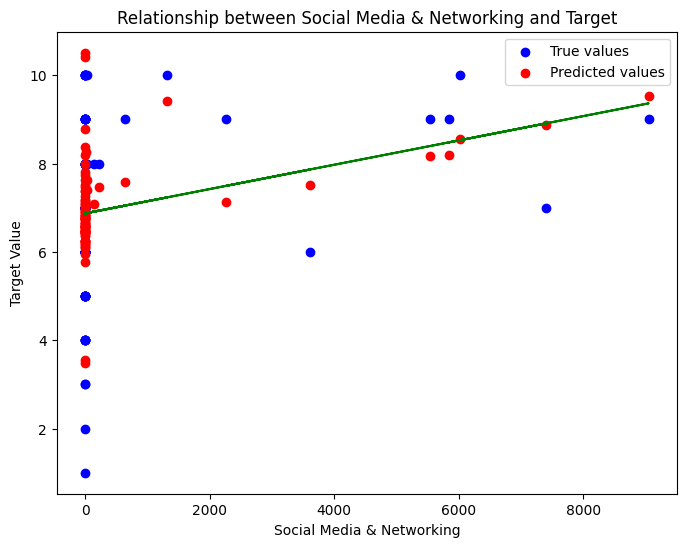

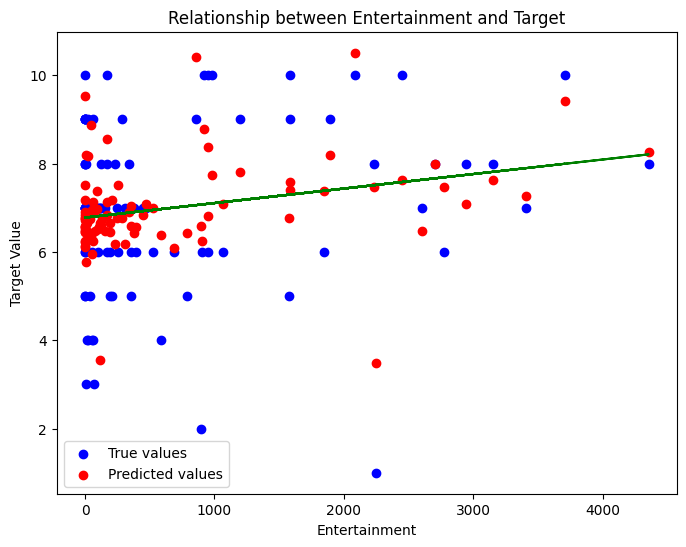

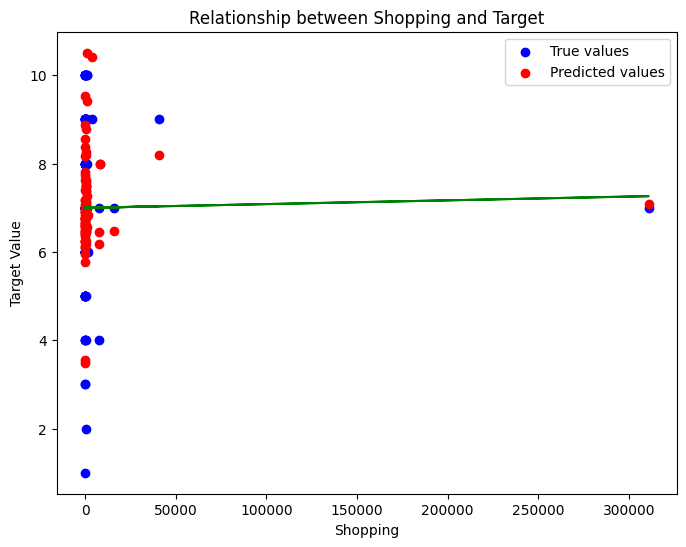

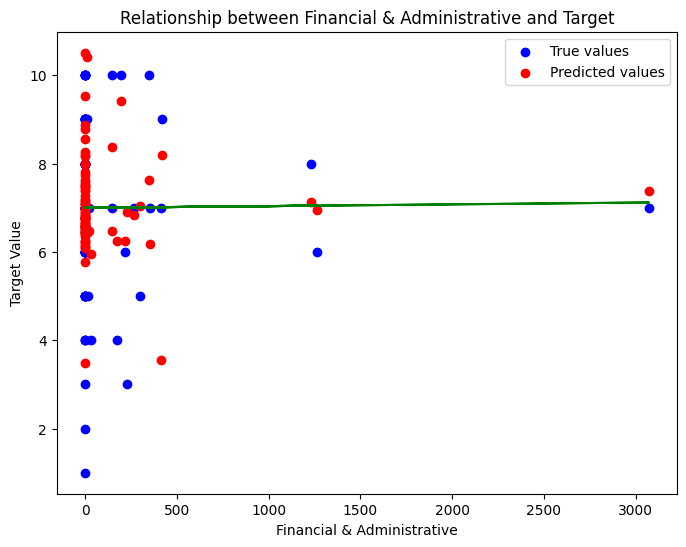

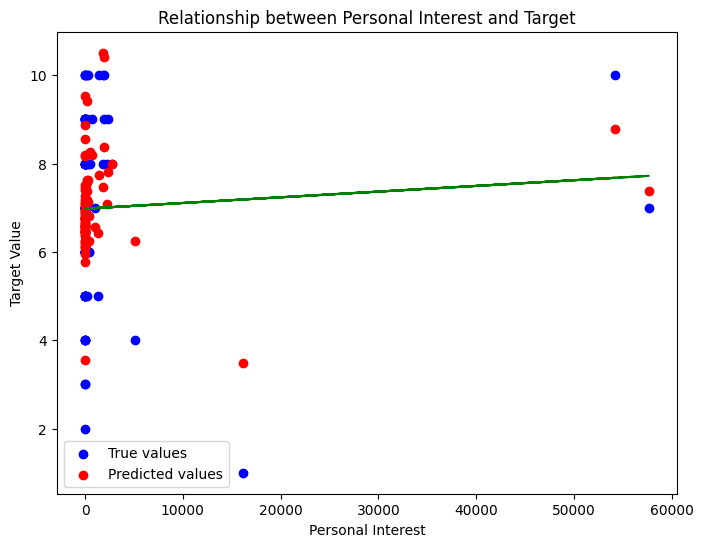

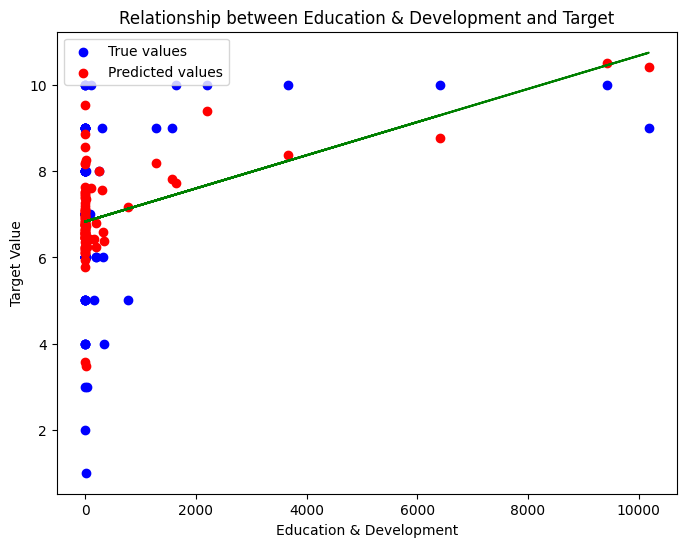

In [23]:

for category in catlist:
    plt.figure(figsize=(8, 6))
    
    # Scatter plots
    plt.scatter(X[category], y, color='blue', label='True values')  # Original data
    plt.scatter(X[category], y_pred, color='red', label='Predicted values')  # Model's predictions
    
    # Generate and plot trendline for the original data
    m, b = np.polyfit(X[category], y, 1)  # 1 for linear regression
    plt.plot(X[category], m*X[category] + b, color='green')  # Trendline
    
    # Rest of the plotting properties
    plt.title(f"Relationship between {category} and Target")
    plt.xlabel(category)
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()


MORE ADVANCED ML!

Time Segmentation: Instead of just having total time, segment the day into logical parts (morning, afternoon, evening) and calculate usage stats for each segment.

Aggregate Features: Calculate sums, means, medians, etc., of the time spent across various categories.

Interaction Features: Consider creating interaction terms between categories that might have synergistic effects on productivity.

In [24]:
# Normalize dataset
X_normalized = (X - X.mean()) / X.std()
y = y.values.ravel()

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Define the MLPClassifier with a reduced number of neurons in the hidden layer
clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)  # Reduced neurons to 50

# Define hyperparameters to tune
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],  # Regularization strengths
    'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'solver': ['adam', 'sgd']  # Optimization algorithms
}

# Use GridSearchCV with k-fold cross-validation (let's say k=5)
grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)  # n_jobs=-1 uses all available cores for computation

# Fit the model
grid_clf.fit(X_train, y_train)

# Display the best hyperparameters
print("Best hyperparameters:", grid_clf.best_params_)

# Predict on train and test set using the best estimator
train_preds = grid_clf.best_estimator_.predict(X_train)
test_preds = grid_clf.best_estimator_.predict(X_test)

# Compute accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)
mse = mean_squared_error(y_test, )

print(f"Train accuracy with best hyperparameters:  {train_accuracy}")
print(f"Test accuracy with best hyperparameters:  {test_accuracy}")


/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702:

KeyboardInterrupt: 

Gradient Boosted Tree

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import confusion_matrix


[I 2023-08-25 19:33:00,105] A new study created in memory with name: no-name-f5444fed-25ba-4f62-a66c-a17cf4bec474


/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-08-25 19:33:00,443] Trial 0 finished with value: 0.803030303030303 and parameters: {'learning_rate': 0.19858909951561

Number of finished trials:  100
Best trial:
  Value:  0.8181818181818182
  Params: 
    learning_rate: 0.18482238234050585
    n_estimators: 85
    max_depth: 4
    subsample: 0.7605691217477284
    colsample_bytree: 0.9795514754163793
    gamma: 0.016210690340941792
    alpha: 0.12103585992649979
    lambda: 1.8867364622941039
[0]	validation_0-mlogloss:2.09308
[1]	validation_0-mlogloss:1.94005
[2]	validation_0-mlogloss:1.78558
[3]	validation_0-mlogloss:1.66816
[4]	validation_0-mlogloss:1.56979
[5]	validation_0-mlogloss:1.48041
[6]	validation_0-mlogloss:1.40473
[7]	validation_0-mlogloss:1.35155
[8]	validation_0-mlogloss:1.29596
[9]	validation_0-mlogloss:1.23502
[10]	validation_0-mlogloss:1.18390
[11]	validation_0-mlogloss:1.14217
[12]	validation_0-mlogloss:1.09585


/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/teddyfoley/vspro/distractionPatterns-main/distractionPatterns/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-mlogloss:1.06162
[14]	validation_0-mlogloss:1.03375
[15]	validation_0-mlogloss:1.01656
[16]	validation_0-mlogloss:0.98871
[17]	validation_0-mlogloss:0.96464
[18]	validation_0-mlogloss:0.93628
[19]	validation_0-mlogloss:0.91881
[20]	validation_0-mlogloss:0.90401
[21]	validation_0-mlogloss:0.88966
[22]	validation_0-mlogloss:0.87746
[23]	validation_0-mlogloss:0.86682
[24]	validation_0-mlogloss:0.85184
[25]	validation_0-mlogloss:0.84014
[26]	validation_0-mlogloss:0.83556
[27]	validation_0-mlogloss:0.82417
[28]	validation_0-mlogloss:0.82087
[29]	validation_0-mlogloss:0.81437
[30]	validation_0-mlogloss:0.81092
[31]	validation_0-mlogloss:0.80481
[32]	validation_0-mlogloss:0.80031
[33]	validation_0-mlogloss:0.79721
[34]	validation_0-mlogloss:0.79163
[35]	validation_0-mlogloss:0.78863
[36]	validation_0-mlogloss:0.78728
[37]	validation_0-mlogloss:0.78610
[38]	validation_0-mlogloss:0.77957
[39]	validation_0-mlogloss:0.77985
[40]	validation_0-mlogloss:0.77628
[41]	validation_0-ml

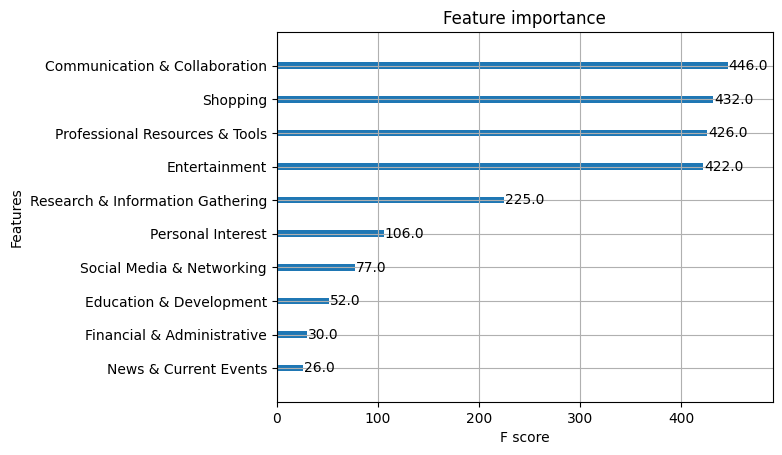

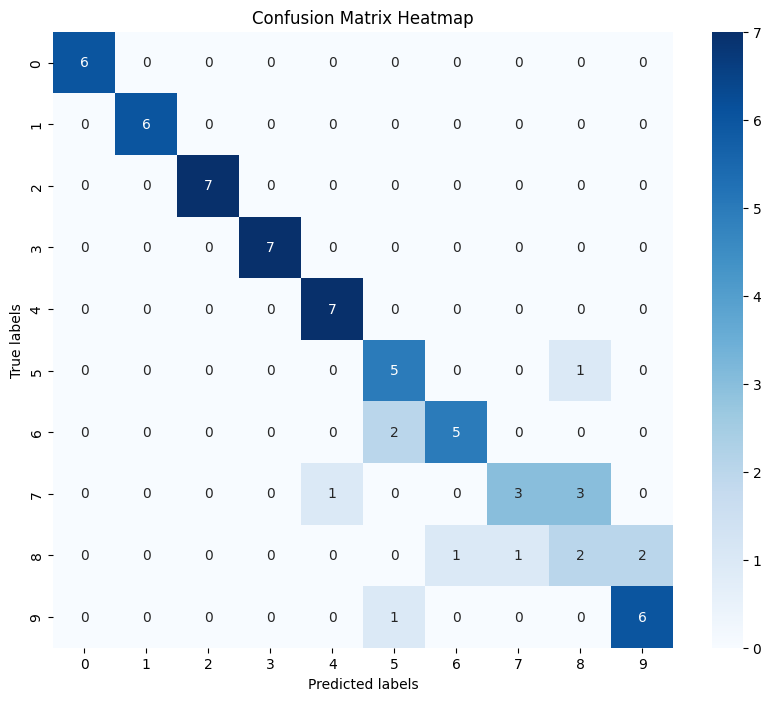

In [26]:
# Normalize dataset
X_normalized = (X - X.mean()) / X.std()

# Use stratified train-test split
stratified_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ensure y is an integer for multi-class classification with XGBoost
y = y.astype(int)

# Oversample the data to handle class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_normalized, y)
y_resampled = y_resampled - 1
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Define objective function for Optuna optimization
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 75, 125),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.1),
        'alpha': trial.suggest_float('alpha', 0, 0.3),
        'lambda': trial.suggest_float('lambda', 1.6, 2)
    }
    clf = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False)
    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test)], verbose=False)
    return accuracy_score(y_test, clf.predict(X_test))

# Create study object and specify direction is 'maximize' for accuracy
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)  # Here, 100 is the number of trials, adjust as necessary.

# Results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Now, you can use the best hyperparameters to train your final model or further analysis.
best_params = trial.params
clf_best = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False)
clf_best.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test)])

# Continue with predictions and evaluation as in your previous code...
# Predict on train and test set using the best estimator
train_preds = clf_best.predict(X_train)
test_preds = clf_best.predict(X_test)

# Compute accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Print other metrics
print(f"Train F1-score: {f1_score(y_train, train_preds, average='macro')}")
print(f"Test F1-score: {f1_score(y_test, test_preds, average='macro')}")
print(f"Train Precision: {precision_score(y_train, train_preds, average='macro')}")
print(f"Test Precision: {precision_score(y_test, test_preds, average='macro')}")
print(f"Train Recall: {recall_score(y_train, train_preds, average='macro')}")
print(f"Test Recall: {recall_score(y_test, test_preds, average='macro')}")

# ROC-AUC is typically used for binary classification problems. For multiclass problems, you'll need to adapt it.
# If your problem is binary, you can use roc_auc_score. If it's multiclass, consider using other metrics or converting ROC-AUC for multiclass.

print(f"Train accuracy with best hyperparameters:  {train_accuracy}")
print(f"Test accuracy with best hyperparameters:  {test_accuracy}")


print("\nClassification Report:\n", classification_report(y_test, test_preds))

xgb.plot_importance(clf_best)
plt.show()

conf_matrix = confusion_matrix(y_test, test_preds)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=list(set(y_test)), yticklabels=list(set(y_test)))

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
